In [160]:
from climpyrical.gridding import find_nearest_index, find_element_wise_nearest_pos
from climpyrical.mask import gen_raster_mask_from_vector
import climpyrical.spytialProcess as sp


from rpy2.robjects.packages import importr
import xarray as xr
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon
from scipy.interpolate import NearestNDInterpolator
from tqdm import tqdm
import dask.array as da
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
import matplotlib



importr("fields")

rpy2.robjects.packages.Package as a <module 'fields'>

In [161]:
dsold = xr.open_dataset('/home/nannau/nrc_data/rain_CanRCM4-LE_ens35_1951-2016_ann_sum_ensmean.nc')
dsold_max = dsold.rlat.values.max()

ds = xr.open_dataset('./data/processed/pre_processed.nc')
mask = xr.open_dataset('./data/processed/canada_mask_rp.nc')['mask'].values

In [162]:
station_dv = 'RL50 (kPa)'
dv = 'Rain-RL50'

df = pd.read_csv('./data/processed/processed_station.csv')
df_nrc = pd.read_csv('./data/processed/nrc_locations.csv')

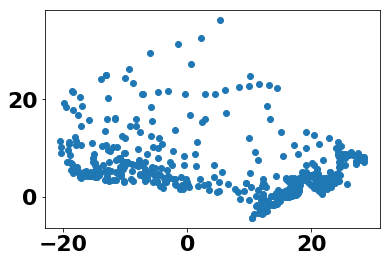

In [163]:
import matplotlib.pyplot as plt
plt.scatter(df.rlon, df.rlat)
plt.show()

In [164]:
df_north = df[df.rlat > dsold_max].copy()
df_no_zero = df[df[station_dv] != 0.0]
df_south = df_no_zero[df_no_zero.rlat <= dsold_max].copy()

north_index = df_north.index.values
south_index = df_south.index.values

# Krig the station only values in the north

In [165]:
X_n_d =  np.stack([np.deg2rad(df.lat), np.deg2rad(df.lon)]).T
imax = df.rlat.idxmax(axis=0, skipna=True)

nbrs = NearestNeighbors(n_neighbors=20, metric='haversine').fit(X_n_d)
dist, ind = nbrs.kneighbors(X_n_d)
temp_df = df.iloc[ind[imax]]

xmin, xmax = temp_df.rlon.min(), temp_df.rlon.max()
ymin, ymax = temp_df.rlat.min(), temp_df.rlat.max()

latlon = np.stack([temp_df.rlon, temp_df.rlat])
stats = temp_df[station_dv]

lw, u = find_nearest_index(ds.rlat.values, ymin), find_nearest_index(ds.rlat.values, ymax)
l, r = find_nearest_index(ds.rlon.values, xmin), find_nearest_index(ds.rlon.values, xmax)
ylim = u-lw
xlim = r-l    

z, x, y, cov = sp.fit(latlon, stats, xlim, ylim, extrap=True)

final = ds[dv].values.copy()
final[:, :] = np.nan
final[lw:u, l:r] = z.T

nanmask = ~np.isnan(final)

station_final_north = final.copy()

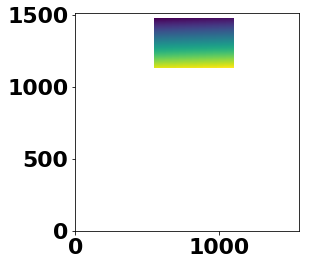

In [166]:
plt.imshow(station_final_north, origin = 'lower')

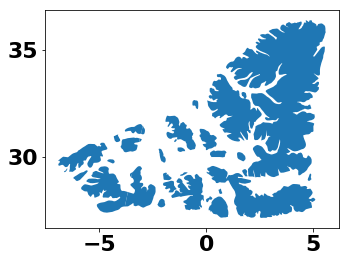

In [167]:
canada = gpd.read_file('./data/processed/canada_final.shp').geometry
def to_polygons(geometries):
    for geometry in geometries:
        if isinstance(geometry, Polygon):
            yield geometry
        else:
            yield from geometry

canada_polygons = MultiPolygon(to_polygons(canada))
polygon_above_north_idx = np.array([p.centroid.y + 1 >= dsold_max for p in canada]) 
M2 = gpd.GeoSeries(MultiPolygon([P for P in canada_polygons if P.centroid.y + 1 >= dsold_max]))
M2.plot()

100%|██████████| 59147/59147 [00:08<00:00, 6626.67it/s]


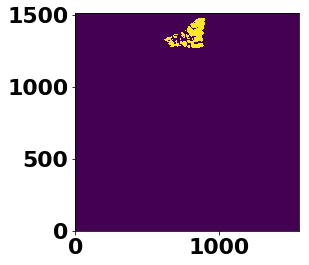

In [168]:
northern_mask = np.zeros(ds[dv].shape) == 1.0
north_ext = 210
northern_mask[-(north_ext+50):, :] = gen_raster_mask_from_vector(
    ds.rlon.values, 
    ds.rlat.values[-(north_ext+50):], 
    M2
)

station_final_north[~northern_mask] = np.nan
plt.imshow(northern_mask, origin='lower')

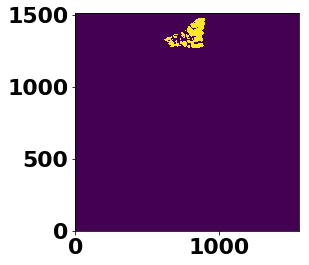

In [169]:
plt.imshow(~np.isnan(station_final_north), origin='lower')

## Find areas in north that are not covered by station only reconstruction

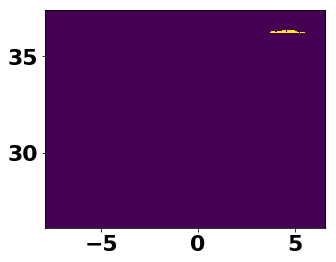

In [170]:
north_nan = ~np.isnan(station_final_north)
missed_station_only = (northern_mask^north_nan)

extent = [ds.rlon.values.min(), ds.rlon.values.max(), ds.rlat.values.min(), ds.rlat.values.max()]

plt.imshow(missed_station_only, origin='lower', extent=extent)
plt.gca().set_ylim(M2.bounds.miny.min()-1, M2.bounds.maxy.max()+1)
plt.gca().set_xlim(M2.bounds.minx.min()-1, M2.bounds.maxx.max()+1)
plt.show()

# station_final_north[~northern_mask] = np.nan

rlon, rlat = np.meshgrid(ds.rlon, ds.rlat)
f = NearestNDInterpolator(np.stack([rlon[north_nan], rlat[north_nan]]).T, station_final_north[north_nan])

station_final_north_filled = station_final_north.copy()
station_final_north_filled[missed_station_only] = f(np.stack([rlon[missed_station_only], rlat[missed_station_only]]).T)

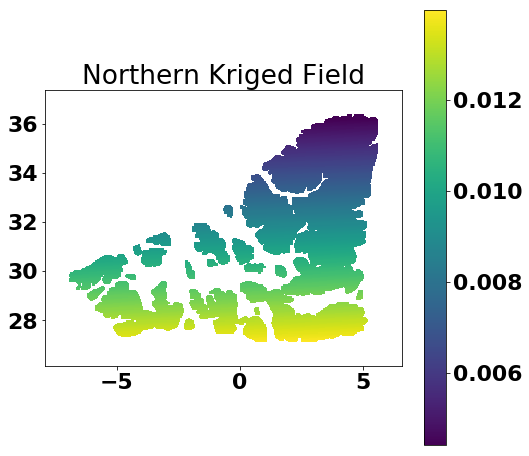

In [171]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

extent = [ds.rlon.values.min(), ds.rlon.values.max(), ds.rlat.values.min(), ds.rlat.values.max()]
fig, ax = plt.subplots(figsize=(8, 8))
img = ax.imshow(station_final_north_filled, origin='lower', extent = extent)
ax.set_ylim(M2.bounds.miny.min()-1, M2.bounds.maxy.max()+1)
ax.set_xlim(M2.bounds.minx.min()-1, M2.bounds.maxx.max()+1)
plt.colorbar(img)
plt.title("Northern Kriged Field")
plt.savefig("northern_krig")

In [172]:
ix, iy = find_element_wise_nearest_pos(
            ds.rlon.values, 
            ds.rlat.values, 
            df.rlon.values, 
            df.rlat.values
)

df['ilocy'] = iy 
df['ilocx'] = ix

In [173]:
# choose starting value
model_vals = ds[dv].values[df.ilocy.values, df.ilocx.values]
station_vals = df[station_dv]
start = np.nanmean(station_vals/model_vals)

# enter tolerances
tol = np.linspace(start-0.8, start+0.8, 1000)

if np.nanmean(station_vals - model_vals) >= 0:
    rmtols = np.array([np.nanmean(df[station_dv] - (model_vals/t)) for t in tol])
    best_tol = tol[np.where(np.diff(np.sign(rmtols)) != 0.)[0][0]]

if np.nanmean(station_vals - model_vals) < 0:
    rmtols = np.array([np.nanmean(df[station_dv] - (model_vals/t)) for t in tol])
    best_tol = tol[np.where(np.diff(np.sign(rmtols)) != 0.)[0][0]]

print(tol.min(), "<=", best_tol, "<=", tol.max())

# apply correction
model_vals_corrected = model_vals/best_tol
mean_corrected = ds[dv].values/best_tol

0.21719585039600764 <= 0.9026813358814931 <= 1.8171958503960077


In [155]:
Zl = []

X_distances = np.stack([np.deg2rad(df.lat.values[south_index]), np.deg2rad(df.lon.values[south_index])])
dx = ((np.amax(ds.rlon.values)-np.amin(ds.rlon.values))/ds.rlon.size)
dy = ((np.amax(ds.rlat.values)-np.amin(ds.rlat.values))/ds.rlat.size)
dA = dx*dy

def krig_at_field(ds, df):
        
    xmin, xmax = temp_df.rlon.min(), temp_df.rlon.max()
    ymin, ymax = temp_df.rlat.min(), temp_df.rlat.max()

    latlon = np.stack([temp_df.rlon, temp_df.rlat])
    stats = temp_df.ratio

    lw, u = find_nearest_index(ds.rlat.values, ymin), find_nearest_index(ds.rlat.values, ymax)
    l, r = find_nearest_index(ds.rlon.values, xmin), find_nearest_index(ds.rlon.values, xmax)

    ylim = u-lw
    xlim = r-l

    latlon = np.stack([temp_df.rlon, temp_df.rlat])
    stats = temp_df.ratio

    z, x, y, cov = sp.fit(latlon, stats, xlim, ylim, extrap=False)

    final = ds[dv].values.copy()
    final[:] = np.nan
    final[lw:u, l:r] = z.T
    
    return final

with tqdm(total=len(south_index), position=0, leave=True) as pbar:
    for i in south_index:
        pbar.update()
        nn = 40

        nbrs = NearestNeighbors(n_neighbors=nn, metric='haversine').fit(X_distances.T)
        dist, ind = nbrs.kneighbors(X_distances.T)
        temp_df = df.iloc[ind[i]]

        latlon = np.stack([temp_df.rlon, temp_df.rlat])
        stats = temp_df.ratio
        hull = ConvexHull(points=latlon.T)
        stats = temp_df.ratio


        while hull.area < dA*(3*10)**2:
            nn+=1
            nbrs = NearestNeighbors(n_neighbors=nn, metric='haversine').fit(X_distances.T)
            dist, ind = nbrs.kneighbors(X_distances.T)

            temp_df = df.iloc[ind[i]]
            hull = ConvexHull(points=latlon.T)

        try:
            final = krig_at_field(ds, temp_df)
            final_da = da.from_array(final, chunks=(500, 500))
            Zl.append(final_da)
        except:
            continue

 46%|████▌     | 190/411 [02:02<03:07,  1.18it/s]R[write to console]: Error in solve.default(qr.R(qr.VT)) : 
  Lapack routine dgesv: system is exactly singular: U[1,1] = 0

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages

R[write to console]: Timing stopped at: 0.266 0 0.262

 48%|████▊     | 199/411 [02:12<04:09,  1.18s/it]R[write to console]: Error in solve.default(qr.R(qr.VT)) : 
  Lapack routine dgesv: system is exactly singular: U[1,1] = 0

R[write to console]: Timing stopped at: 2.394 0.004 2.395

 57%|█████▋    | 235/411 [02:48<01:28,  1.99it/s]R[write to console]: Error in solve.default(qr.R(qr.VT)) : 
  Lapack routine dgesv: system is exactly singular: U[1,1] = 0

R[write to console]: Timing stopped at: 0.233 0 0.232



In [134]:
cxmin, cxmax, cymin, cymax = canada.bounds.minx.min(), canada.bounds.maxx.max(), canada.bounds.miny.min(), canada.bounds.maxy.max()

In [174]:
final = np.zeros(ds[dv].shape)
final = da.stack(Zl, axis=0)
final = da.nanmean(final, axis = 0)
ratio = final.compute()
ratio[~mask] = np.nan

/home/nannau/tri/lib/python3.6/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [175]:
nanmask = ~np.isnan(ratio)
rlon, rlat = np.meshgrid(ds.rlon, ds.rlat)
ratio_final = ratio.copy()

f = NearestNDInterpolator(np.stack([rlon[nanmask], rlat[nanmask]]).T, ratio[nanmask])

ratio_final[nanmask^mask] = f(np.stack([rlon[nanmask^mask], rlat[nanmask^mask]]).T)
ratio_final = ratio_final*mean_corrected

In [176]:
from shapely.geometry import MultiPolygon
pts=[]
for poly in canada:
    if isinstance(poly, MultiPolygon):
        for p in poly:
            pts.extend(p.exterior.coords)
            pts.append([None, None])
    else:
        pts.extend(poly.exterior.coords)
        pts.append([None, None])

X, Y = zip(*pts)

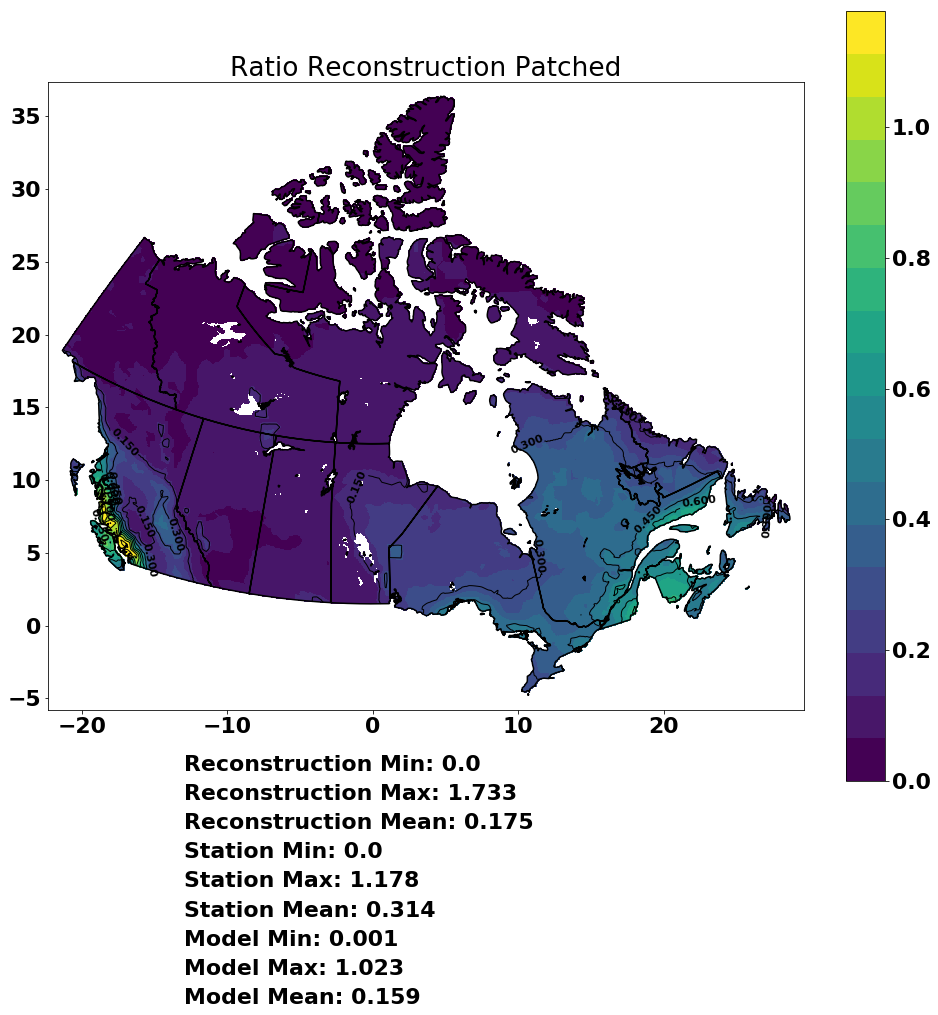

In [178]:
ratio_final[northern_mask] = 0.0#np.array(station_final_north_filled)[northern_mask]
ratio_final[~mask] = np.nan
fig, ax = plt.subplots(figsize=(15, 15))

vmax = np.nanmax(df[station_dv].values)

ax.text(-13, -10, 'Reconstruction Min: {}'.format(np.round(np.nanmin(ratio_final), 3)))
ax.text(-13, -12, 'Reconstruction Max: {}'.format(np.round(np.nanmax(ratio_final), 3)))
ax.text(-13, -14, 'Reconstruction Mean: {}'.format(np.round(np.nanmean(ratio_final), 3)))


ax.text(-13, -16, 'Station Min: {}'.format(np.round(np.min(df[station_dv]), 3)))
ax.text(-13, -18, 'Station Max: {}'.format(np.round(np.max(df[station_dv]), 3)))
ax.text(-13, -20, 'Station Mean: {}'.format(np.round(np.nanmean(df[station_dv]), 3)))

ax.text(-13, -22, 'Model Min: {}'.format(np.round(np.nanmin(ds[dv]), 3)))
ax.text(-13, -24, 'Model Max: {}'.format(np.round(np.nanmax(ds[dv]), 3)))
ax.text(-13, -26, 'Model Mean: {}'.format(np.round(np.nanmean(ds[dv]), 3)))

col1 = ax.imshow(ratio_final, origin='lower', extent=extent, vmax=vmax, cmap = plt.cm.get_cmap("viridis", 18))
CS = ax.contour(ds.rlon, ds.rlat, ratio_final, 12, colors='black', linewidths=1, zorder=4)
plt.colorbar(col1, ax = ax, fraction=0.046, pad=0.05)

ax.set_xlim(cxmin-1, cxmax+1)
ax.set_ylim(cymin-1, cymax+1)

ax.clabel(CS, fontsize=11, inline=1)
ax.set_title('Ratio Reconstruction Patched')
canada.plot(ax=ax, color='red', zorder=0)
ax.plot(X, Y, color='black')

plt.savefig('RL50-non-interp-full-reconstruction-patched.png')